<a href="https://colab.research.google.com/github/joshthesteez/Uber-Data-Analysis/blob/main/UberAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GOALS**

1.  **User Behavior Analysis**


*   What are the most common purposes for Uber rides?
*   How often do users take Uber rides? Are there any patterns based on time of day, day of the week, or month?


2.   **Ride Metrics**


*   What is the average distance and duration of Uber rides?
*   Is there a correlation between ride distance and duration?
* How do ride metrics vary across different purposes (e.g. *business vs. personal rides*)


3.   **Geographical Insights**


*   Which locations or routes are the most popular for Uber rides?
*   Is there a relationship between ride location and prupose?


4.   **Seasonal Trends**


*   When does the demand for Uber rides spike? When does it drop?






# Imports and File Structure

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

file_path = "/content/drive/MyDrive/Colab_Notebooks/ML_Portfolio/Uber Data Visualization/UberDataset.csv"

if not os.path.exists(file_path):
    print(f"ERROR: '{file_path}' does not exist")
else:
    # read the dataset into a pandas dataframe and inspect its properties
    dataset = pd.read_csv(file_path)


    print("dataset before preprocessing: \n")
    print(dataset.head())
    print(f"Shape: {dataset.shape}\n")
    print(dataset.info())



dataset before preprocessing: 

         START_DATE          END_DATE  CATEGORY        START             STOP  \
0  01-01-2016 21:11  01-01-2016 21:17  Business  Fort Pierce      Fort Pierce   
1  01-02-2016 01:25  01-02-2016 01:37  Business  Fort Pierce      Fort Pierce   
2  01-02-2016 20:25  01-02-2016 20:38  Business  Fort Pierce      Fort Pierce   
3  01-05-2016 17:31  01-05-2016 17:45  Business  Fort Pierce      Fort Pierce   
4  01-06-2016 14:42  01-06-2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              NaN  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  
Shape: (1156, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non

# Data Preprocessing
We need to:

1.   Get rid of all the null values in the **PURPOSE** column
2.   Change the **START_DATE** and **END_DATE** columns to ***datetime*** format
3.   Split the **START_DATE** and **END_DATE** columns into into a *date* and *time* column and establish 4 '*time zones*' for the day
4.   Drop any duplicate rows and rows with null values



In [35]:
  # replace null values in PURPOSE column with NOT values
  dataset['PURPOSE'].fillna(value="NOT", inplace=True)
  # change the datatype of START_DATE & END_DATE to date_time format
  dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], errors='coerce')
  dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], errors='coerce')

  # split the START_DATE and END_DATE columns into date and time columns
  dataset['date'] = pd.DatetimeIndex(dataset['START_DATE']).date
  dataset['time'] = pd.DatetimeIndex(dataset['START_DATE']).hour

  # establish 4 time zones for the day
  dataset['day-night'] = pd.cut(x=dataset['time'],
                                  bins = [0,10,15,19,24],
                                  labels = ['Morning', 'Afternoon', 'Evening', 'Night'])

  # drop null values and duplicate columns
  dataset.dropna(inplace=True)
  dataset.drop_duplicates(inplace=True)

  print("dataset after preprocessing: \n")
  print(dataset.head())
  print(f"Shape: {dataset.shape}\n")
  print(dataset.info())

dataset after preprocessing: 

           START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:00 2016-01-05 17:45:00  Business  Fort Pierce   
4 2016-01-06 14:42:00 2016-01-06 15:49:00  Business  Fort Pierce   

              STOP  MILES          PURPOSE        date  time  day-night   DAY  
0      Fort Pierce    5.1   Meal/Entertain  2016-01-01    21      Night   Fri  
1      Fort Pierce    5.0              NOT  2016-01-02     1    Morning   Sat  
2      Fort Pierce    4.8  Errand/Supplies  2016-01-02    20      Night   Sat  
3      Fort Pierce    4.7          Meeting  2016-01-05    17    Evening  Tues  
4  West Palm Beach   63.7   Customer Visit  2016-01-06    14  Afternoon   Wed  
Shape: (413, 11)

<class 'pandas.core.frame.DataFrame'>
Index: 413 entries, 0 to

# Data Visualization

First lets look at how many unique values are located in columns with object datatypes, these will be our '*categorical*' columns

In [41]:
obj = (dataset.dtypes == 'object') & (dataset.dtypes == 'category')
object_cols = dataset.select_dtypes(include=['object', 'category']).columns.tolist()

unique_vals = {}
for col in object_cols:
    try:
        unique_vals[col] = dataset[col].unique().size
        print(f"Unique values in column '{col}': {unique_vals[col]}")
    except KeyError as e:
        print(f"Error: Column '{col}' not found in the DataFrame.")
        continue

Unique values in column 'CATEGORY': 2
Unique values in column 'START': 108
Unique values in column 'STOP': 112
Unique values in column 'PURPOSE': 7
Unique values in column 'date': 113
Unique values in column 'day-night': 4
Unique values in column 'DAY': 7


These unique values tell us how much variability exists in the object columns:

A ***high*** count suggests that there is a lot of diversity in the data of that respective column, so for categforical data like we have, we see that there are a lot of options, especially in our location and date columns.

Conversely, a ***low*** unique value count, as seen in our **CATEGORY** and **PURPOSE** column shows us that there are not a lot of classifications for our data, so there will be less variance and more consistency within these columns.

# User Behavior Analysis

Looking at the **CATEGORY** column, we see that there are two options: *Business* and *Personal*

Lets compare the amount of trips taken for Business vs. Personal

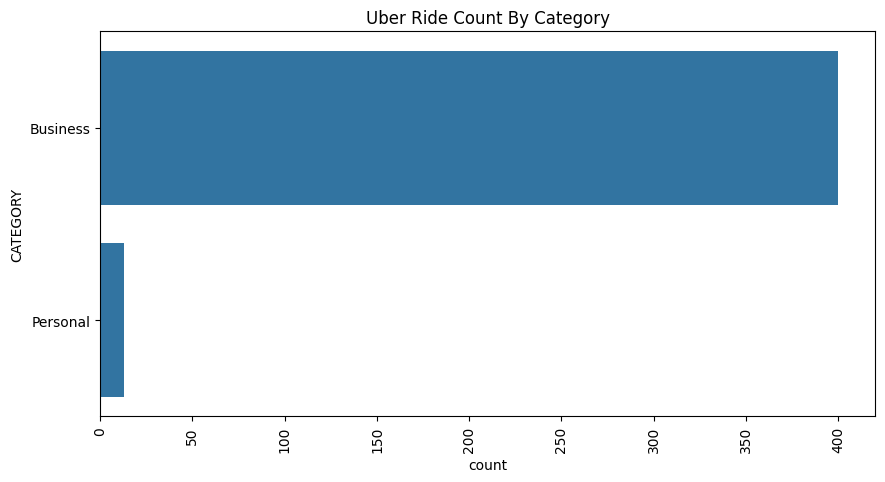

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(dataset['CATEGORY'])
plt.xticks(rotation=90)
plt.title('Uber Ride Count By Category')

plt.show()

We see that the vast majority of trips taken are for **Business**, thus the statistical significance of **Personal** trips is negligible

Now lets graph the **Purpose** column to answer the question:

What are the most common purposes for Uber rides?

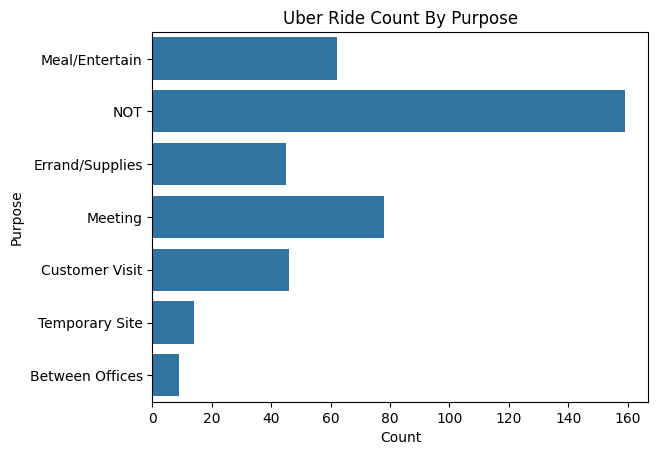

In [33]:
sns.countplot(dataset['PURPOSE'])
plt.xlabel('Count')
plt.ylabel('Purpose')
plt.title('Uber Ride Count By Purpose')
plt.show()

As we can see, most customers decided to leave the **PURPOSE** column blank, so lets exclude it from our graph

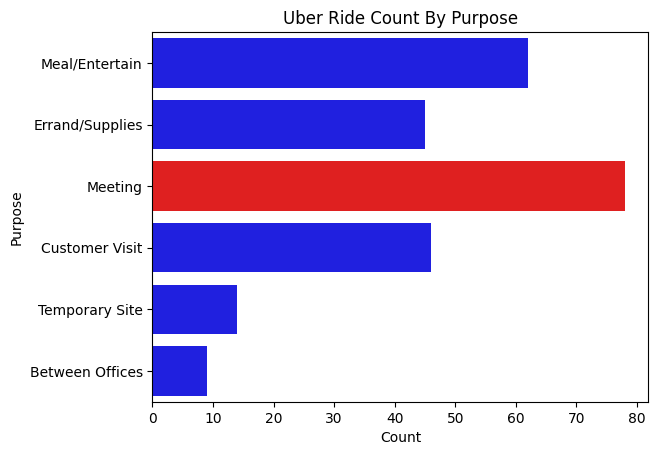

In [32]:
# remove the 'NOT' category from our results
data_wo_NOT = dataset[dataset['PURPOSE'] != 'NOT']

palette = {'Meeting': 'red',
           'Meal/Entertain' : 'blue',
           'Between Offices' : 'blue',
           'Customer Visit' : 'blue',
           'Temporary Site' : 'blue',
           'Errand/Supplies' : 'blue'}

sns.countplot(data=data_wo_NOT,
              y='PURPOSE',
              hue='PURPOSE',
              legend=False,
              palette=palette)

plt.xlabel('Count')
plt.ylabel('Purpose')
plt.title('Uber Ride Count By Purpose')

plt.show()

Now we can clearly see that the most popular reason for ordering an Uber is for Meetings

Now, let's break down the **day-night** column to see when the most popular time to order an Uber is on any given day:

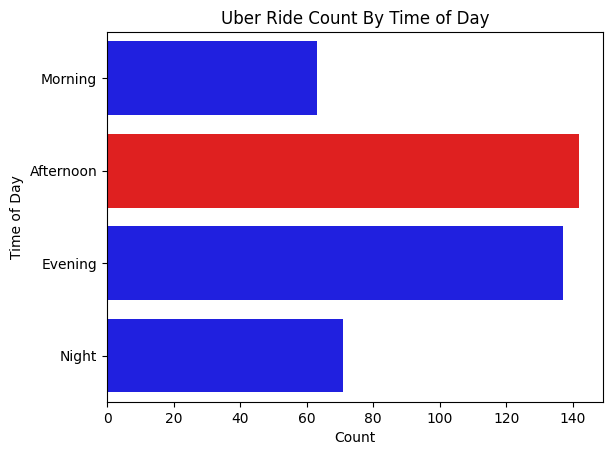

In [34]:
palette = {'Afternoon' : 'red',
           'Evening' : 'blue',
           'Night' : 'blue',
           'Morning' : 'blue',}

sns.countplot(data=dataset,
              y='day-night',
              hue='day-night',
              legend=False,
              palette=palette)

plt.xlabel('Count')
plt.ylabel('Time of Day')
plt.title('Uber Ride Count By Time of Day')

plt.show()

As we can see, most customers order an Uber in the afternoon. Earlier we defined the hours

10:00AM - 3:00PM | Afternoon

Now let's see what day is the most popular:

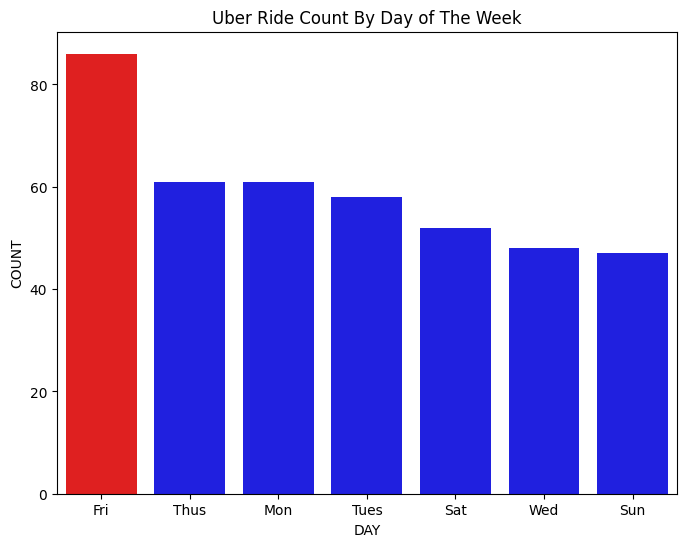

In [29]:
# Map weekdays to day labels
day_labels = {0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thus', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
dataset['DAY'] = dataset.START_DATE.dt.weekday.map(day_labels)

palette = {'Mon': 'blue', 'Tues': 'blue', 'Wed': 'blue', 'Thus': 'blue',
           'Fri': 'red', 'Sat': 'blue', 'Sun': 'blue'}

# Calculate day counts
day_counts = dataset['DAY'].value_counts()

# Create barplot with custom colors for weekdays
plt.figure(figsize=(8, 6))
sns.barplot(x=day_counts.index,
            y=day_counts.values,
            hue=day_counts.index,
            palette=palette,
            dodge=False)

plt.xlabel('DAY')
plt.ylabel('COUNT')
plt.title('Uber Ride Count By Day of The Week')

plt.show()

Now using a heatmap, we can visualize the correlation between the time of day and the day of the week:

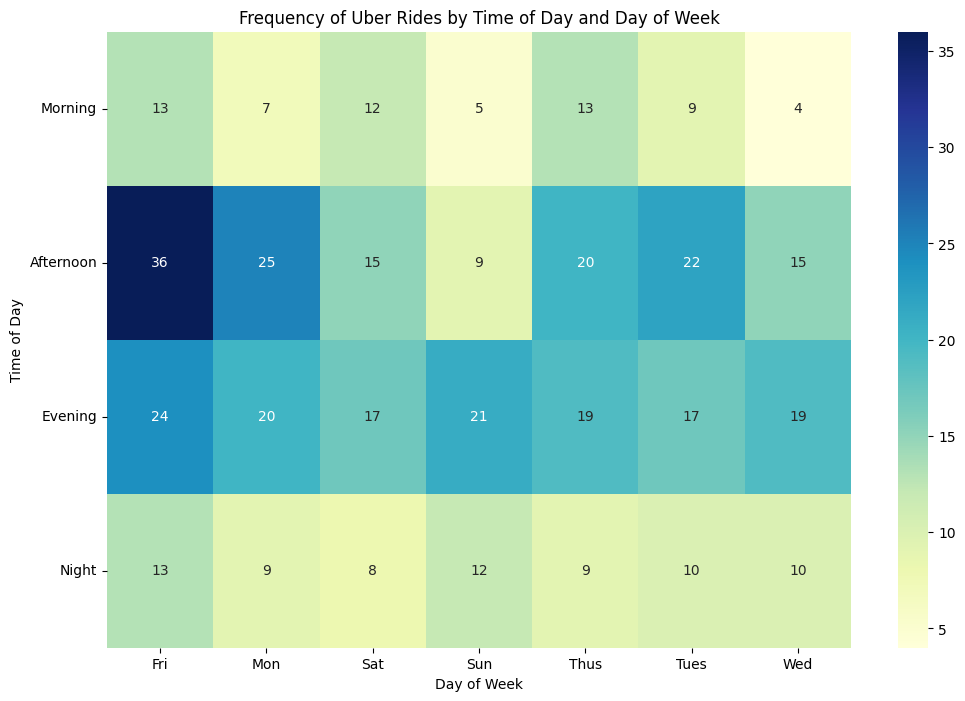

In [15]:
# Convert 'day-night' to categorical to ensure proper ordering in the heatmap
dataset['day-night'] = pd.Categorical(dataset['day-night'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)

# Count the frequency of each combination of 'day-night' and 'day_of_week'
heatmap_data = dataset.groupby(['day-night', 'DAY']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g', cbar=True)
plt.title('Frequency of Uber Rides by Time of Day and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Time of Day')
plt.yticks(rotation=0)  # Ensures 'day-night' labels are horizontal
plt.show()

This heatmap tells us that the most popular time to order an Uber is Friday Afternoon, with most users ordering an Uber in the Afternoon or Evening regardless of the day

# Ride Metrics

Now let's visualize the average distance and duration

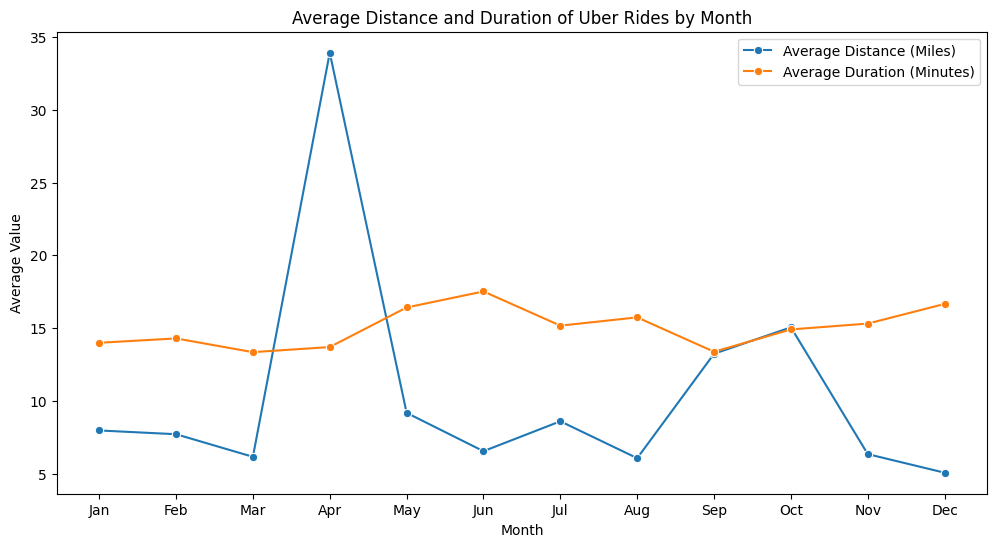

In [51]:
# extract the month component from the 'START-DATE' column
dataset['MONTH'] = pd.DatetimeIndex(dataset['START_DATE']).month

month_label = {1.0: 'Jan',
               2.0: 'Feb',
               3.0: 'Mar',
               4.0: 'Apr',
               5.0: 'May',
               6.0: 'Jun',
               7.0: 'Jul',
               8.0: 'Aug',
               9.0: 'Sep',
               10.0: 'Oct',
               11.0: 'Nov',
               12.0: 'Dec'}

# Calculate average distance per month
avg_distance_per_month = dataset.groupby('MONTH')['MILES'].mean().reset_index()
avg_distance_per_month.rename(columns={'MILES': 'AVG_DISTANCE'}, inplace=True)

# Calculate average duration per month
avg_duration_per_month = dataset.groupby('MONTH')['time'].mean().reset_index()
avg_duration_per_month.rename(columns={'time': 'AVG_DURATION_MINUTES'}, inplace=True)

# Merge average distance and duration DataFrames
avg_distance_duration_per_month = pd.merge(avg_distance_per_month, avg_duration_per_month, on='MONTH')

# Set plot size
plt.figure(figsize=(12, 6))

# Plot Average Distance
sns.lineplot(x='MONTH', y='AVG_DISTANCE', data=avg_distance_duration_per_month, marker='o', label='Average Distance (Miles)')

# Plot Average Duration
sns.lineplot(x='MONTH', y='AVG_DURATION_MINUTES', data=avg_distance_duration_per_month, marker='o', label='Average Duration (Minutes)')

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Average Value')
plt.title('Average Distance and Duration of Uber Rides by Month')
plt.xticks(avg_distance_duration_per_month['MONTH'], [month_label[m] for m in avg_distance_duration_per_month['MONTH']])
plt.legend()

# Show plot
plt.show()


We see here that the majority of Uber Rides take 13-17 minutes to complete, with an average distance of <10 miles except for the months of April, where we see an outlier for ride distanc at over 30 miles, and again some longer rides in September/October at 13-15 miles.

Now lets use a scatterplot to understand the correlation between average ride distance and duration



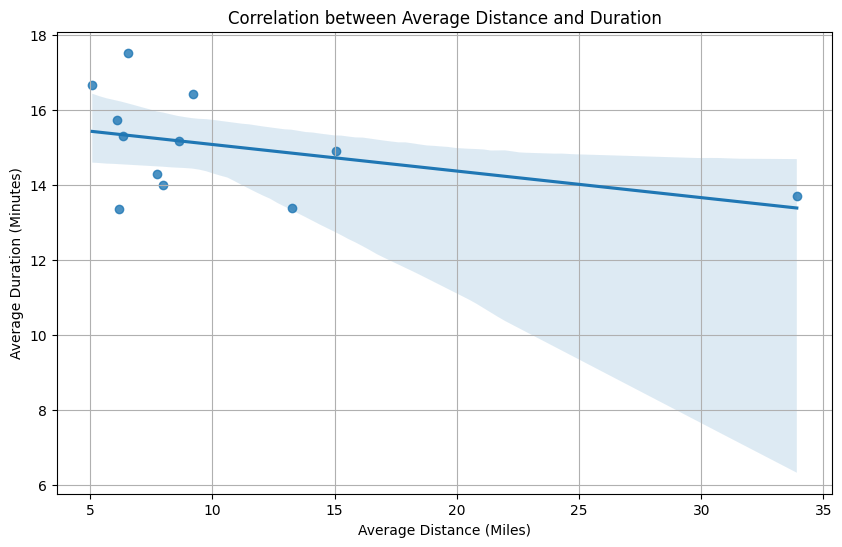

In [69]:
plt.figure(figsize=(10, 6))
sns.regplot(x='AVG_DISTANCE', y='AVG_DURATION_MINUTES', data=avg_distance_duration_per_month)
plt.title('Correlation between Average Distance and Duration')
plt.xlabel('Average Distance (Miles)')
plt.ylabel('Average Duration (Minutes)')
plt.grid(True)
plt.show()

Now we will look at ride distance to see if there is anything worth noting.

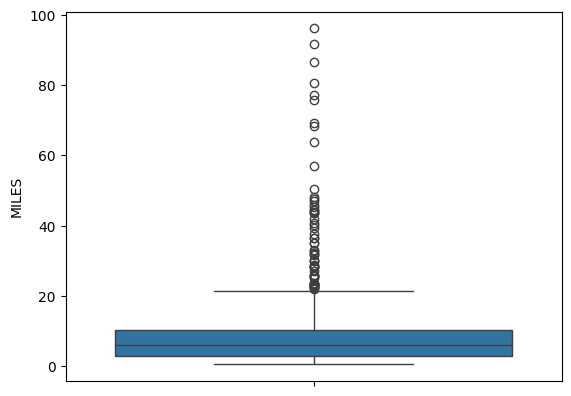

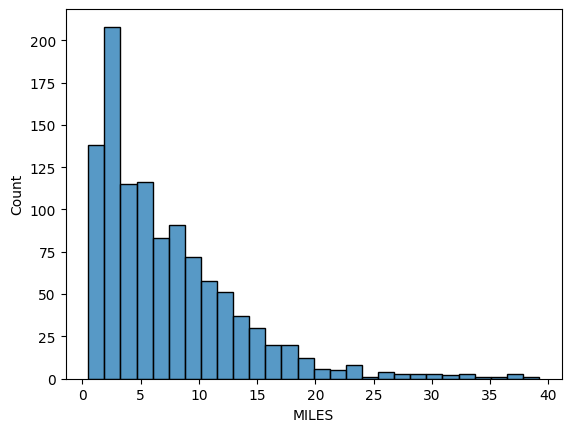

In [ ]:
sns.boxplot(dataset[dataset['MILES']<100]['MILES'])
plt.show()

sns.histplot(dataset[dataset['MILES']<40]['MILES'])
plt.show()

Judging by the boxplot, we see that the majority of rides are within a distance of 0 - 10 miles.

Narrowing in on this range with the histplot, we see that an overwhelming majority of Uber rides were within a distance of roughly 2 miles, with some rides being 10 miles or more, and an overwhelming majority of rides are under 25 miles in distance.